In [1]:
import pandas as pd
import numpy as np
from numba import njit, prange

from tqdm.notebook import tqdm, trange

from numba.typed import List
from numba import types

from numba_progress import ProgressBar

import math

In [2]:
users = 226570
items = 231637
genres = 552

train_data = pd.read_csv("../Preprocessing/processed_dataframes/train.csv")
validation_data = pd.read_csv("../Preprocessing/processed_dataframes/val.csv")

In [3]:
uir_train = train_data.values

uir_val = validation_data.values
n_val = uir_val.shape[0]

In [4]:
@njit
def get_items_rated_by_users(train_data, n_users):
    res = List([List.empty_list(types.int64) for _ in range(n_users)])
    
    for u, i, _ in train_data:
        res[u].append(i)
    
    for u in range(n_users):
        res[u].sort()
    
    return res

# irbu = get_items_rated_by_users(uir_train, users)
irbu = get_items_rated_by_users(np.vstack([uir_train, uir_val]), users)

In [5]:
import scipy.sparse as sparse

tags_mat = sparse.load_npz("../Preprocessing/objects/tags_matrix.npz")

In [9]:
def get_tags_item_belongs_to(tags_mat, n_items):
    res = List([List.empty_list(types.int64) for _ in range(n_items)])
    
    for row, col in zip(*tags_mat.nonzero()):
        res[row].append(col)
        
    return res

tibt = get_tags_item_belongs_to(tags_mat, items)

In [10]:
@njit
def step(
    train_data, 
    Rus,
    Gis,
    n_users, 
    n_items, 
    k, 
    α1,
    α2,
    α3,
    α4,
    α5,
    α6,
    λ1, 
    λ2,
    λ3,
    λ4,
    λ5,
    λ6,
    μ, bi, bu, P, Q, Y, X,
):
    loss = 0
    for u, i, r in train_data:
        Ru = Rus[u]
        sqrt_Ru = np.sqrt(len(Ru))

        implicit_feedback = np.zeros(k)
        for j in Ru:
            implicit_feedback += Y[j]
        implicit_feedback /= (sqrt_Ru+1e-15)
        
        Gi = Gis[i]
        genres_feedback = np.zeros(k)
        for g in Gi:
            genres_feedback += X[g]
        genres_feedback /= len(Gi)

        pred = μ + bu[u] + bi[i] + np.dot(Q[i] + genres_feedback, P[u] + implicit_feedback)
        error = r - pred

        # Updating
        bu[u] += α1 * (error - λ1*bu[u])
        bi[i] += α2 * (error - λ2*bi[i])

        Pu = P[u]
        Qi = Q[i]
        P[u] += α3*(error*Qi - λ3*Pu)
        Q[i] += α4*(error*(Pu+implicit_feedback) - λ4*Qi)
    
        term_1 = error*(1/len(Gi))*(Pu + implicit_feedback)
        for g in Gi:
            X[g] += α6*(term_1 - λ5*X[g])
            
        term_2 = error*(1/sqrt_Ru)*(Qi + genres_feedback)
        for j in Ru:
            Y[j] += α5*(term_2 - λ6*Y[j])
            
        loss += error**2
            
    return np.sqrt(loss/len(train_data))

In [11]:
# RS HD page 171 (chrome), 84 book
def fit_gsvdpp(
    train_data, val_data, Rus, Gis, n_users, n_items, n_tags, k, 
    α1=.01, α2=.01, α3=.01, α4=.01, α5=.01, α6=.06, 
    λ1=.01, λ2=.01, λ3=.01, λ4=.01, λ5=.01, λ6=.01, n_iters=20
):
    """
    train_data: array Nx3
    """
    val_ui = uir_val[:, :2]
    val_exp = uir_val[:, -1]
    
    bu = np.zeros(n_users, np.double)
    bi = np.zeros(n_items, np.double)
    
    P = np.random.normal(0, .1, (n_users, k))
    Q = np.random.normal(0, .1, (n_items, k))
    Y = np.random.normal(0, .1, (n_items, k))
    X = np.random.normal(0, .1, (n_tags, k))
    
    μ = np.mean(train_data[:, 2])
    
    model_params = None
    best_epoch = 0
    prev_val_loss = math.inf
    
    t = trange(n_iters, leave=True)
    for it in t:
        loss = step(
            train_data, Rus, Gis, n_users, n_items, k, 
            α1, α2, α3, α4, α5, α6,
            λ1, λ2, λ3, λ4, λ5, λ6, 
            μ, bi, bu, P, Q, Y, X
        )
        \
        
        val_preds = predict_batch(val_ui, Rus, Gis, (μ, bu, bi, P, Q, Y, X))
        val_loss = np.sqrt(1/n_val * np.sum((val_preds - val_exp)**2))
        t.set_postfix({"Loss": loss, "Val": val_loss})
        
        if val_loss < prev_val_loss:
            prev_val_loss = val_loss
            model_params = (μ, bu.copy(), bi.copy(), P.copy(), Q.copy(), Y.copy(), X.copy())
            best_epoch = it
    
#     return μ, bu, bi, P, Q, Y
    return model_params

## Fit

In [12]:
@njit
def predict(u, i, Rus, Gis, params):
    μ, bu, bi, P, Q, Y, X = params
    k = P.shape[1]
    
    Ru = Rus[u]
    sqrt_Ru = np.sqrt(len(Ru))

    implicit_feedback = np.zeros(k)
    for j in Ru:
        implicit_feedback += Y[j]
    implicit_feedback /= (sqrt_Ru+1e-15)
    
    Gi = Gis[i]
    genres_feedback = np.zeros(k)
    for g in Gi:
        genres_feedback += X[g]
    genres_feedback /= len(Gi)

    pred = μ + bu[u] + bi[i] + np.dot(Q[i] + genres_feedback, P[u] + implicit_feedback)
    
    return pred

In [13]:
@njit(parallel=True, nogil=True)
def predict_batch(ui_mat, Rus, Gis, params):
    predictions = np.zeros(len(ui_mat))
    for it in prange(ui_mat.shape[0]):
        u, i = ui_mat[it]
        predictions[it] = predict(u, i, Rus, Gis, params)
        
    return np.clip(predictions, 1., 5.)

In [29]:
α1 = 0.005
α2 = 0.005
α3 = 0.006
α4 = 0.006
α5 = 0.006
α6 = 0.006
k = 5

fitted_params = fit_gsvdpp(
    uir_train, uir_val, irbu, tibt, users, items, genres, k, 
    α1, α2, α3, α4, α5, α6,
    λ1=0.02, λ2=0.02, λ3=.015, λ4=.01, λ5=.01, λ6=.01,
    n_iters=15,
)

val_preds = predict_batch(uir_val[:, :2], irbu, tibt, fitted_params)
val_expected = uir_val[:, 2]

error = np.sqrt(1/n_val * np.sum((val_preds - val_expected)**2))
print(error)

0.899842917864599


In [14]:
α1 = 0.005
α2 = 0.005
α3 = 0.005
α4 = 0.005
α5 = 0.005
α6 = 0.005
λ1 = 0.01
λ2 = 0.01
λ3 = 0.1
λ4 = 0.1
λ5 = 0.1
λ6 = 0.1
k = 4

fitted_params = fit_gsvdpp(
    uir_train, uir_val, irbu, tibt, users, items, genres, k, 
    α1, α2, α3, α4, α5, α6,
    λ1, λ2, λ3, λ4, λ5, λ6,
    n_iters=25,
)

val_preds = predict_batch(uir_val[:, :2], irbu, tibt, fitted_params)
val_expected = uir_val[:, 2]

error = np.sqrt(1/n_val * np.sum((val_preds - val_expected)**2))
print(error)

  0%|          | 0/25 [00:00<?, ?it/s]

0.898708381079073


In [11]:
α1 = 0.005
α2 = 0.005
α3 = 0.005
α4 = 0.005
α5 = 0.005
α6 = 0.005
λ1 = 0.01
λ2 = 0.01
λ3 = 0.1
λ4 = 0.1
λ5 = 0.1
λ6 = 0.1
k = 3

fitted_params = fit_gsvdpp(
    uir_train, uir_val, irbu, tibt, users, items, genres, k, 
    α1, α2, α3, α4, α5, α6,
    λ1, λ2, λ3, λ4, λ5, λ6,
    n_iters=25,
)

val_preds = predict_batch(uir_val[:, :2], irbu, tibt, fitted_params)
val_expected = uir_val[:, 2]

error = np.sqrt(1/n_val * np.sum((val_preds - val_expected)**2))
print(error)

  0%|          | 0/25 [00:00<?, ?it/s]

0.898636143013218


In [12]:
α1 = 0.005
α2 = 0.005
α3 = 0.005
α4 = 0.005
α5 = 0.005
α6 = 0.005
λ1 = 0.01
λ2 = 0.01
λ3 = 0.1
λ4 = 0.1
λ5 = 0.1
λ6 = 0.1
k = 2

fitted_params = fit_gsvdpp(
    uir_train, uir_val, irbu, tibt, users, items, genres, k, 
    α1, α2, α3, α4, α5, α6,
    λ1, λ2, λ3, λ4, λ5, λ6,
    n_iters=25,
)

val_preds = predict_batch(uir_val[:, :2], irbu, tibt, fitted_params)
val_expected = uir_val[:, 2]

error = np.sqrt(1/n_val * np.sum((val_preds - val_expected)**2))
print(error)

  0%|          | 0/25 [00:00<?, ?it/s]

0.8986372737281625


In [13]:
import matplotlib.pyplot as plt

In [14]:
_, _, _, Pu, Qi, _, _ = fitted_params
print(Pu.shape, Qi.shape)

(226570, 2) (231637, 2)


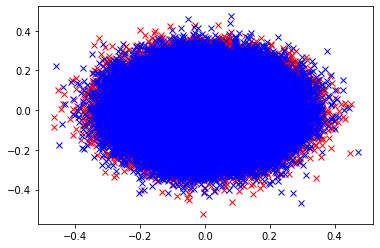

In [18]:
plt.plot(Pu[:, 0], Pu[:, 1], "rx")
plt.plot(Qi[:, 0], Qi[:, 1], "bx")
plt.show()